In [ ]:
# default_exp models.layers

# Layers

> Helper function used to build PyTorch timeseries models.

In [ ]:
#export
from torch.nn.init import normal_
from fastai.torch_core import Module
from fastai.layers import *
from torch.nn.utils import weight_norm, spectral_norm
from tsai.imports import *
from tsai.utils import *

In [ ]:
#export
def noop(x): return x

In [ ]:
#export
def init_lin_zero(m):
    if isinstance(m, (nn.Linear)): 
        if getattr(m, 'bias', None) is not None: nn.init.constant_(m.bias, 0)
        nn.init.constant_(m.weight, 0)
    for l in m.children(): init_lin_zero(l)
        
lin_zero_init = init_lin_zero

In [ ]:
#export    
class SwishBeta(Module):
    def __init__(self, beta=1.): 
        self.sigmoid = torch.sigmoid
        self.beta = nn.Parameter(torch.Tensor(1).fill_(beta).to(default_device()))
    def forward(self, x): return x.mul(self.sigmoid(x*self.beta))

In [ ]:
#export
def same_padding1d(seq_len, ks, stride=1, dilation=1):
    "Same padding formula as used in Tensorflow"
    p = (seq_len - 1) * stride + (ks - 1) * dilation + 1 - seq_len
    return p // 2, p - p // 2


class Pad1d(nn.ConstantPad1d):
    def __init__(self, padding, value=0.):
        super().__init__(padding, value)


@delegates(nn.Conv1d)
class Conv1dSame(Module):
    "Conv1d with padding='same'"
    def __init__(self, ni, nf, ks=3, stride=1, dilation=1, **kwargs):
        self.ks, self.stride, self.dilation = ks, stride, dilation
        self.conv1d_same = nn.Conv1d(ni, nf, ks, stride=stride, dilation=dilation, **kwargs)
        self.weight = self.conv1d_same.weight
        self.bias = self.conv1d_same.bias
        self.pad = Pad1d

    def forward(self, x):
        self.padding = same_padding1d(x.shape[-1], self.ks, dilation=self.dilation) #stride=self.stride not used in padding calculation!
        return self.conv1d_same(self.pad(self.padding)(x))

In [ ]:
init_linear(Conv1dSame(2, 3, 3), None, init='auto', bias_std=.01)

In [ ]:
bs = 2
c_in = 3
c_out = 5
seq_len = 6
t = torch.rand(bs, c_in, seq_len)
test_eq(Conv1dSame(c_in, c_out, ks=3, stride=1, dilation=1, bias=False)(t).shape, (bs, c_out, seq_len))
test_eq(Conv1dSame(c_in, c_out, ks=3, stride=1, dilation=2, bias=False)(t).shape, (bs, c_out, seq_len))
test_eq(Conv1dSame(c_in, c_out, ks=3, stride=2, dilation=1, bias=False)(t).shape, (bs, c_out, seq_len//2))
test_eq(Conv1dSame(c_in, c_out, ks=3, stride=2, dilation=2, bias=False)(t).shape, (bs, c_out, seq_len//2))

In [ ]:
#export
def same_padding2d(H, W, ks, stride=(1, 1), dilation=(1, 1)):
    "Same padding formula as used in Tensorflow"
    if isinstance(ks, Integral): ks = (ks, ks)
    if ks[0] == 1:  p_h = 0
    else:  p_h = (H - 1) * stride[0] + (ks[0] - 1) * dilation[0] + 1 - H
    if ks[1] == 1:  p_w = 0
    else:  p_w = (W - 1) * stride[1] + (ks[1] - 1) * dilation[1] + 1 - W
    return (p_w // 2, p_w - p_w // 2, p_h // 2, p_h - p_h // 2)


class Pad2d(nn.ConstantPad2d):
    def __init__(self, padding, value=0.):
        super().__init__(padding, value)


@delegates(nn.Conv2d)
class Conv2dSame(Module):
    "Conv2d with padding='same'"
    def __init__(self, ni, nf, ks=(3, 3), stride=(1, 1), dilation=(1, 1), **kwargs):
        if isinstance(ks, Integral): ks = (ks, ks)
        if isinstance(stride, Integral): stride = (stride, stride)
        if isinstance(dilation, Integral): dilation = (dilation, dilation)
        self.ks, self.stride, self.dilation = ks, stride, dilation
        self.conv2d_same = nn.Conv2d(ni, nf, ks, stride=stride, dilation=dilation, **kwargs)
        self.weight = self.conv2d_same.weight
        self.bias = self.conv2d_same.bias
        self.pad = Pad2d

    def forward(self, x):
        self.padding = same_padding2d(x.shape[-2], x.shape[-1], self.ks, dilation=self.dilation) #stride=self.stride not used in padding calculation!
        return self.conv2d_same(self.pad(self.padding)(x))
    
    
@delegates(nn.Conv2d)
def Conv2d(ni, nf, kernel_size=None, ks=None, stride=1, padding='same', dilation=1, init='auto', bias_std=0.01, **kwargs):
    "conv1d layer with padding='same', 'valid', or any integer (defaults to 'same')"
    assert not (kernel_size and ks), 'use kernel_size or ks but not both simultaneously'
    assert kernel_size is not None or ks is not None, 'you need to pass a ks'
    kernel_size = kernel_size or ks
    if padding == 'same': 
        conv = Conv2dSame(ni, nf, kernel_size, stride=stride, dilation=dilation, **kwargs)
    elif padding == 'valid': conv = nn.Conv2d(ni, nf, kernel_size, stride=stride, padding=0, dilation=dilation, **kwargs)
    else: conv = nn.Conv2d(ni, nf, kernel_size, stride=stride, padding=padding, dilation=dilation, **kwargs)
    init_linear(conv, None, init=init, bias_std=bias_std)
    return conv

In [ ]:
bs = 2
c_in = 3
c_out = 5
h = 16
w = 20
t = torch.rand(bs, c_in, h, w)
test_eq(Conv2dSame(c_in, c_out, ks=3, stride=1, dilation=1, bias=False)(t).shape, (bs, c_out, h, w))
test_eq(Conv2dSame(c_in, c_out, ks=(3, 1), stride=1, dilation=1, bias=False)(t).shape, (bs, c_out, h, w))
test_eq(Conv2dSame(c_in, c_out, ks=3, stride=(1, 1), dilation=(2, 2), bias=False)(t).shape, (bs, c_out, h, w))
test_eq(Conv2dSame(c_in, c_out, ks=3, stride=(2, 2), dilation=(1, 1), bias=False)(t).shape, (bs, c_out, h//2, w//2))
test_eq(Conv2dSame(c_in, c_out, ks=3, stride=(2, 2), dilation=(2, 2), bias=False)(t).shape, (bs, c_out, h//2, w//2))
test_eq(Conv2d(c_in, c_out, ks=3, padding='same', stride=1, dilation=1, bias=False)(t).shape, (bs, c_out, h, w))

In [ ]:
#export
class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super(Chomp1d, self).__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        return x[:, :, :-self.chomp_size].contiguous()

In [ ]:
#export
# Modified from https://github.com/locuslab/TCN/blob/master/TCN/tcn.py
class Conv1dCausal(Module):
    def __init__(self, ni, nf, ks, stride=1, dilation=1, **kwargs):
        padding = (ks - 1) * dilation
        self.conv_causal = nn.Conv1d(ni, nf, ks, stride=stride, padding=padding, dilation=dilation, **kwargs)
        self.weight = self.conv_causal.weight
        self.bias = self.conv_causal.bias
        self.chomp_size = padding

    def forward(self, x):
        x = self.conv_causal(x)
        return x[..., :-self.chomp_size].contiguous()

In [ ]:
init_linear(Conv1dCausal(2, 3, 3), None, init='auto', bias_std=.01)

In [ ]:
bs = 2
c_in = 3
c_out = 5
seq_len = 512
t = torch.rand(bs, c_in, seq_len)
dilation = 1
test_eq(Conv1dCausal(c_in, c_out, ks=3, dilation=dilation)(t).shape, Conv1dSame(c_in, c_out, ks=3, dilation=dilation)(t).shape)
dilation = 2
test_eq(Conv1dCausal(c_in, c_out, ks=3, dilation=dilation)(t).shape, Conv1dSame(c_in, c_out, ks=3, dilation=dilation)(t).shape)

In [ ]:
#export
@delegates(nn.Conv1d)
def Conv1d(ni, nf, kernel_size=None, ks=None, stride=1, padding='same', dilation=1, init='auto', bias_std=0.01, **kwargs):
    "conv1d layer with padding='same', 'causal', 'valid', or any integer (defaults to 'same')"
    assert not (kernel_size and ks), 'use kernel_size or ks but not both simultaneously'
    assert kernel_size is not None or ks is not None, 'you need to pass a ks'
    kernel_size = kernel_size or ks
    if padding == 'same': 
        if kernel_size%2==1: 
            conv = nn.Conv1d(ni, nf, kernel_size, stride=stride, padding=kernel_size//2 * dilation, dilation=dilation, **kwargs)
        else:
            conv = Conv1dSame(ni, nf, kernel_size, stride=stride, dilation=dilation, **kwargs)
    elif padding == 'causal': conv = Conv1dCausal(ni, nf, kernel_size, stride=stride, dilation=dilation, **kwargs)
    elif padding == 'valid': conv = nn.Conv1d(ni, nf, kernel_size, stride=stride, padding=0, dilation=dilation, **kwargs)
    else: conv = nn.Conv1d(ni, nf, kernel_size, stride=stride, padding=padding, dilation=dilation, **kwargs)
    init_linear(conv, None, init=init, bias_std=bias_std)
    return conv

In [ ]:
bs = 2
ni = 3
nf = 5
seq_len = 6
ks = 3
t = torch.rand(bs, c_in, seq_len)
test_eq(Conv1d(ni, nf, ks, padding=0)(t).shape, (bs, c_out, seq_len - (2 * (ks//2))))
test_eq(Conv1d(ni, nf, ks, padding='valid')(t).shape, (bs, c_out, seq_len - (2 * (ks//2))))
test_eq(Conv1d(ni, nf, ks, padding='same')(t).shape, (bs, c_out, seq_len))
test_eq(Conv1d(ni, nf, ks, padding='causal')(t).shape, (bs, c_out, seq_len))
test_error('use kernel_size or ks but not both simultaneously', Conv1d, ni, nf, kernel_size=3, ks=3)
test_error('you need to pass a ks', Conv1d, ni, nf)

In [ ]:
conv = Conv1d(ni, nf, ks, padding='same')
init_linear(conv, None, init='auto', bias_std=.01)
conv

Conv1d(3, 5, kernel_size=(3,), stride=(1,), padding=(1,))

In [ ]:
conv = Conv1d(ni, nf, ks, padding='causal')
init_linear(conv, None, init='auto', bias_std=.01)
conv

Conv1dCausal(
  (conv_causal): Conv1d(3, 5, kernel_size=(3,), stride=(1,), padding=(2,))
)

In [ ]:
conv = Conv1d(ni, nf, ks, padding='valid')
init_linear(conv, None, init='auto', bias_std=.01)
weight_norm(conv)
conv

Conv1d(3, 5, kernel_size=(3,), stride=(1,))

In [ ]:
conv = Conv1d(ni, nf, ks, padding=0)
init_linear(conv, None, init='auto', bias_std=.01)
weight_norm(conv)
conv

Conv1d(3, 5, kernel_size=(3,), stride=(1,))

In [ ]:
#export
class SeparableConv1d(Module):
    def __init__(self, ni, nf, ks, stride=1, padding='same', dilation=1, bias=True, bias_std=0.01):
        self.depthwise_conv = Conv1d(ni, ni, ks, stride=stride, padding=padding, dilation=dilation, groups=ni, bias=bias)
        self.pointwise_conv = nn.Conv1d(ni, nf, 1, stride=1, padding=0, dilation=1, groups=1, bias=bias)
        if bias:
            if bias_std != 0: 
                normal_(self.depthwise_conv.bias, 0, bias_std)
                normal_(self.pointwise_conv.bias, 0, bias_std)
            else: 
                self.depthwise_conv.bias.data.zero_()
                self.pointwise_conv.bias.data.zero_()

    def forward(self, x):
        x = self.depthwise_conv(x)
        x = self.pointwise_conv(x)
        return x

In [ ]:
bs = 64
c_in = 6
c_out = 5
seq_len = 512
t = torch.rand(bs, c_in, seq_len)
test_eq(SeparableConv1d(c_in, c_out, 3)(t).shape, (bs, c_out, seq_len))

In [ ]:
#export
class AddCoords1d(Module):
    """Add coordinates to ease position identification without modifying mean and std"""
    def forward(self, x):
        bs, _, seq_len = x.shape
        cc = torch.linspace(-1,1,x.shape[-1]).repeat(bs, 1, 1).to(x.device)
        cc = (cc - cc.mean()) / cc.std()
        x = torch.cat([x, cc], dim=1)
        return x

In [ ]:
bs = 2
c_in = 3
c_out = 5
seq_len = 50

t = torch.rand(bs, c_in, seq_len)
t = (t - t.mean()) / t.std()
test_eq(AddCoords1d()(t).shape, (bs, c_in + 1, seq_len))
new_t = AddCoords1d()(t)
test_close(new_t.mean(),0, 1e-2)
test_close(new_t.std(), 1, 1e-2)

In [ ]:
#export
class ConvBlock(nn.Sequential):
    "Create a sequence of conv1d (`ni` to `nf`), activation (if `act_cls`) and `norm_type` layers."
    def __init__(self, ni, nf, kernel_size=None, ks=3, stride=1, padding='same', bias=None, bias_std=0.01, norm='Batch', zero_norm=False, bn_1st=True,
                 act=nn.ReLU, act_kwargs={}, init='auto', dropout=0., xtra=None, coord=False, separable=False,  **kwargs):
        kernel_size = kernel_size or ks
        ndim = 1
        layers = [AddCoords1d()] if coord else []
        norm_type = getattr(NormType,f"{snake2camel(norm)}{'Zero' if zero_norm else ''}") if norm is not None else None
        bn = norm_type in (NormType.Batch, NormType.BatchZero)
        inn = norm_type in (NormType.Instance, NormType.InstanceZero)
        if bias is None: bias = not (bn or inn)
        if separable: conv = SeparableConv1d(ni + coord, nf, ks=kernel_size, bias=bias, stride=stride, padding=padding, **kwargs)
        else: conv = Conv1d(ni + coord, nf, ks=kernel_size, bias=bias, stride=stride, padding=padding, **kwargs)
        act = None if act is None else act(**act_kwargs)
        if not separable: init_linear(conv, act, init=init, bias_std=bias_std)
        if   norm_type==NormType.Weight:   conv = weight_norm(conv)
        elif norm_type==NormType.Spectral: conv = spectral_norm(conv)
        layers += [conv]
        act_bn = []        
        if act is not None: act_bn.append(act)
        if bn: act_bn.append(BatchNorm(nf, norm_type=norm_type, ndim=ndim))
        if inn: act_bn.append(InstanceNorm(nf, norm_type=norm_type, ndim=ndim))
        if bn_1st: act_bn.reverse()
        if dropout: layers += [nn.Dropout(dropout)]
        layers += act_bn
        if xtra: layers.append(xtra)
        super().__init__(*layers)     
                            
Conv = partial(ConvBlock, norm=None, act=None)
ConvBN = partial(ConvBlock, norm='Batch', act=None)
ConvIN = partial(ConvBlock, norm='Instance', act=None)
CoordConv = partial(ConvBlock, norm=None, act=None, coord=True)
CoordConvBN = partial(ConvBlock, norm='Batch', act=None, coord=True)
SepConv = partial(ConvBlock, norm=None, act=None, separable=True)
SepConvBN = partial(ConvBlock, norm='Batch', act=None, separable=True)
SepConvIN = partial(ConvBlock, norm='Instance', act=None, separable=True)
SepCoordConv = partial(ConvBlock, norm=None, act=None, coord=True, separable=True)
SepCoordConvBN = partial(ConvBlock, norm='Batch', act=None, coord=True, separable=True)

In [ ]:
#export
class ResBlock1dPlus(Module):
    "Resnet block from `ni` to `nh` with `stride`"
    @delegates(ConvLayer.__init__)
    def __init__(self, expansion, ni, nf, coord=False, stride=1, groups=1, reduction=None, nh1=None, nh2=None, dw=False, g2=1,
                 sa=False, sym=False, norm='Batch', zero_norm=True, act_cls=defaults.activation, ks=3,
                 pool=AvgPool, pool_first=True, **kwargs):
        if nh2 is None: nh2 = nf
        if nh1 is None: nh1 = nh2
        nf,ni = nf*expansion,ni*expansion
        k0 = dict(norm=norm, zero_norm=False, act=act_cls, **kwargs)
        k1 = dict(norm=norm, zero_norm=zero_norm, act=None, **kwargs)
        convpath  = [ConvBlock(ni,  nh2, ks, coord=coord, stride=stride, groups=ni if dw else groups, **k0),
                     ConvBlock(nh2,  nf, ks, coord=coord, groups=g2, **k1)
        ] if expansion == 1 else [
                     ConvBlock(ni,  nh1, 1, coord=coord, **k0),
                     ConvBlock(nh1, nh2, ks, coord=coord, stride=stride, groups=nh1 if dw else groups, **k0),
                     ConvBlock(nh2,  nf, 1, coord=coord, groups=g2, **k1)]
        if reduction: convpath.append(SEModule(nf, reduction=reduction, act_cls=act_cls))
        if sa: convpath.append(SimpleSelfAttention(nf,ks=1,sym=sym))
        self.convpath = nn.Sequential(*convpath)
        idpath = []
        if ni!=nf: idpath.append(ConvBlock(ni, nf, 1, coord=coord, act=None, **kwargs))
        if stride!=1: idpath.insert((1,0)[pool_first], pool(stride, ndim=1, ceil_mode=True))
        self.idpath = nn.Sequential(*idpath)
        self.act = defaults.activation(inplace=True) if act_cls is defaults.activation else act_cls()

    def forward(self, x): return self.act(self.convpath(x) + self.idpath(x))

In [ ]:
#export
def SEModule1d(ni, reduction=16, act=nn.ReLU, act_kwargs={}):
    "Squeeze and excitation module for 1d"
    nf = math.ceil(ni//reduction/8)*8
    assert nf != 0, 'nf cannot be 0'
    return SequentialEx(nn.AdaptiveAvgPool1d(1), 
                        ConvBlock(ni, nf, ks=1, norm=None, act=act, act_kwargs=act_kwargs),
                        ConvBlock(nf, ni, ks=1, norm=None, act=nn.Sigmoid), ProdLayer())

In [ ]:
t = torch.rand(8, 32, 12)
test_eq(SEModule1d(t.shape[1], 16, act=nn.ReLU, act_kwargs={})(t).shape, t.shape)

In [ ]:
#export
def Norm(nf, ndim=1, norm='Batch', zero_norm=False, init=True, **kwargs):
    "Norm layer with `nf` features and `ndim` with auto init."
    assert 1 <= ndim <= 3
    nl = getattr(nn, f"{snake2camel(norm)}Norm{ndim}d")(nf, **kwargs)
    if nl.affine and init:
        nl.bias.data.fill_(1e-3)
        nl.weight.data.fill_(0. if zero_norm else 1.)
    return nl

BN1d = partial(Norm, ndim=1, norm='Batch')
IN1d = partial(Norm, ndim=1, norm='Instance')

In [ ]:
bs = 2
ni = 3
nf = 5
sl = 4
ks = 5

t = torch.rand(bs, ni, sl)
test_eq(ConvBlock(ni, nf, ks)(t).shape, (bs, nf, sl))
test_eq(ConvBlock(ni, nf, ks, padding='causal')(t).shape, (bs, nf, sl))
test_eq(ConvBlock(ni, nf, ks, coord=True)(t).shape, (bs, nf, sl))
ConvBlock(ni, nf, ks, stride=2)(t).shape
test_eq(ConvBlock(ni, nf, ks, stride=2)(t).shape, (bs, nf, sl//2))

In [ ]:
test_eq(BN1d(ni)(t).shape, (bs, ni, sl))
test_eq(BN1d(ni).weight.data.mean().item(), 1.)
test_eq(BN1d(ni, zero_norm=True).weight.data.mean().item(), 0.)

In [ ]:
test_eq(ConvBlock(ni, nf, ks, norm='batch', zero_norm=True)[1].weight.data.unique().item(), 0)
test_ne(ConvBlock(ni, nf, ks, norm='batch', zero_norm=False)[1].weight.data.unique().item(), 0)
test_eq(ConvBlock(ni, nf, ks, bias=False)[0].bias, None)
ConvBlock(ni, nf, ks, act=Swish, coord=True)

ConvBlock(
  (0): AddCoords1d()
  (1): Conv1d(4, 5, kernel_size=(5,), stride=(1,), padding=(2,), bias=False)
  (2): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Swish()
)

In [ ]:
#export
class LinLnDrop(nn.Sequential):
    "Module grouping `LayerNorm1d`, `Dropout` and `Linear` layers"
    def __init__(self, n_in, n_out, ln=True, p=0., act=None, lin_first=False):
        layers = [nn.LayerNorm(n_out if lin_first else n_in)] if ln else []
        if p != 0: layers.append(nn.Dropout(p))
        lin = [nn.Linear(n_in, n_out, bias=not ln)]
        if act is not None: lin.append(act)
        layers = lin+layers if lin_first else layers+lin
        super().__init__(*layers)

In [ ]:
LinLnDrop(2, 3, p=.5)

LinLnDrop(
  (0): LayerNorm((2,), eps=1e-05, elementwise_affine=True)
  (1): Dropout(p=0.5, inplace=False)
  (2): Linear(in_features=2, out_features=3, bias=False)
)

In [ ]:
#export
class LambdaPlus(Module):
    def __init__(self, func, *args, **kwargs): self.func,self.args,self.kwargs=func,args,kwargs
    def forward(self, x): return self.func(x, *self.args, **self.kwargs)

In [ ]:
#export
class Squeeze(Module):
    def __init__(self, dim=-1): self.dim = dim
    def forward(self, x): return x.squeeze(dim=self.dim)
    def __repr__(self): return f'{self.__class__.__name__}(dim={self.dim})'


class Unsqueeze(Module):
    def __init__(self, dim=-1): self.dim = dim
    def forward(self, x): return x.unsqueeze(dim=self.dim)
    def __repr__(self): return f'{self.__class__.__name__}(dim={self.dim})'


class Add(Module):
    def forward(self, x, y): return x.add(y)
    def __repr__(self): return f'{self.__class__.__name__}'


class Concat(Module):
    def __init__(self, dim=1): self.dim = dim
    def forward(self, *x): return torch.cat(*x, dim=self.dim)
    def __repr__(self): return f'{self.__class__.__name__}(dim={self.dim})'


class Permute(Module):
    def __init__(self, *dims): self.dims = dims
    def forward(self, x): return x.permute(self.dims)
    def __repr__(self): return f"{self.__class__.__name__}(dims={', '.join([str(d) for d in self.dims])})"
    
    
class Transpose(Module):
    def __init__(self, *dims, contiguous=False): self.dims, self.contiguous = dims, contiguous
    def forward(self, x): 
        if self.contiguous: return x.transpose(*self.dims).contiguous()
        else: return x.transpose(*self.dims)
    def __repr__(self): 
        if self.contiguous: return f"{self.__class__.__name__}(dims={', '.join([str(d) for d in self.dims])}).contiguous()"
        else: return f"{self.__class__.__name__}({', '.join([str(d) for d in self.dims])})"
    
    
class View(Module):
    def __init__(self, *shape): self.shape = shape
    def forward(self, x): return x.view(x.shape[0], *self.shape)
    def __repr__(self): return f"{self.__class__.__name__}({', '.join(['bs'] + [str(s) for s in self.shape])})"
    
    
class Reshape(Module):
    def __init__(self, *shape): self.shape = shape
    def forward(self, x): return x.reshape(x.shape[0], *self.shape)
    def __repr__(self): return f"{self.__class__.__name__}({', '.join(['bs'] + [str(s) for s in self.shape])})"
    
    
class Max(Module):
    def __init__(self, dim=None, keepdim=False): self.dim, self.keepdim = dim, keepdim
    def forward(self, x): return x.max(self.dim, keepdim=self.keepdim)[0]
    def __repr__(self): return f'{self.__class__.__name__}(dim={self.dim}, keepdim={self.keepdim})'

    
class LastStep(Module):
    def forward(self, x): return x[..., -1]
    def __repr__(self): return f'{self.__class__.__name__}()'
    
    
class SoftMax(Module):
    "SoftMax layer"
    def __init__(self, dim=-1):
        self.dim = dim
    def forward(self, x):
        return F.softmax(x, dim=self.dim)
    def __repr__(self): return f'{self.__class__.__name__}(dim={self.dim})'    
    
Noop = nn.Sequential()

In [ ]:
bs = 2
nf = 5
sl = 4

t = torch.rand(bs, nf, sl)
test_eq(Permute(0,2,1)(t).shape, (bs, sl, nf))
test_eq(Max(1)(t).shape, (bs, sl))
test_eq(Transpose(1,2)(t).shape, (bs, sl, nf))
test_eq(Transpose(1,2, contiguous=True)(t).shape, (bs, sl, nf))
test_eq(View(-1, 2, 10)(t).shape, (bs, 1, 2, 10))
test_eq(Reshape(-1, 2, 10)(t).shape, (bs, 1, 2, 10))
Transpose(1,2), Permute(0,2,1), View(-1, 2, 10), Transpose(1,2, contiguous=True), Reshape(-1, 2, 10), Noop

(Transpose(1, 2),
 Permute(dims=0, 2, 1),
 View(bs, -1, 2, 10),
 Transpose(dims=1, 2).contiguous(),
 Reshape(bs, -1, 2, 10),
 Sequential())

In [ ]:
#export
class Sharpen(Module):
    "This is used to increase confidence in predictions - MixMatch paper"
    def __init__(self, T=.5): self.T = T
    def forward(self, x):
        x = x**(1. / self.T)
        return x / x.sum(dim=1, keepdims=True)

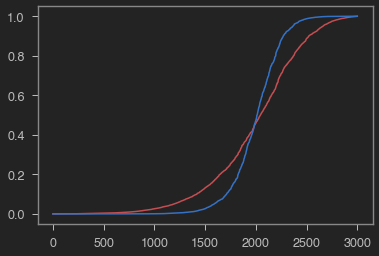

In [ ]:
n_samples = 1000
n_classes = 3

t = (torch.rand(n_samples, n_classes) - .5) * 10
probas = F.softmax(t, -1)
sharpened_probas = Sharpen()(probas)
plt.plot(probas.flatten().sort().values, color='r')
plt.plot(sharpened_probas.flatten().sort().values, color='b')
plt.show()
test_gt(sharpened_probas[n_samples//2:].max(-1).values.sum().item(), probas[n_samples//2:].max(-1).values.sum().item())

In [ ]:
#export
class Sequential(nn.Sequential):
    """Class that allows you to pass one or multiple inputs"""
    def forward(self, *x):
        for i, module in enumerate(self._modules.values()): 
            x = module(*x) if isinstance(x, (list, tuple, L)) else module(x)
        return x

In [ ]:
#export
class TimeDistributed(nn.Module):
    def __init__(self, module, batch_first=False):
        super(TimeDistributed, self).__init__()
        self.module = module
        self.batch_first = batch_first

    def forward(self, x):

        if len(x.size()) <= 2:
            return self.module(x)

        # Squash samples and timesteps into a single axis
        x_reshape = x.contiguous().view(-1, x.size(-1))  # (samples * timesteps, input_size)

        y = self.module(x_reshape)

        # We have to reshape Y
        if self.batch_first:
            y = y.contiguous().view(x.size(0), -1, y.size(-1))  # (samples, timesteps, output_size)
        else:
            y = y.view(-1, x.size(1), y.size(-1))  # (timesteps, samples, output_size)

        return y

In [ ]:
#export
class Temp_Scale(Module):
    "Used to perform Temperature Scaling (dirichlet=False) or Single-parameter Dirichlet calibration (dirichlet=True)"
    def __init__(self, temp=1., dirichlet=False):
        self.weight = nn.Parameter(tensor(temp))
        self.bias = None
        self.log_softmax = dirichlet

    def forward(self, x):
        if self.log_softmax: x = F.log_softmax(x, dim=-1)
        return x.div(self.weight)


class Vector_Scale(Module):
    "Used to perform Vector Scaling (dirichlet=False) or Diagonal Dirichlet calibration (dirichlet=True)"
    def __init__(self, n_classes=1, dirichlet=False):
        self.weight = nn.Parameter(torch.ones(n_classes))
        self.bias = nn.Parameter(torch.zeros(n_classes))
        self.log_softmax = dirichlet

    def forward(self, x):
        if self.log_softmax: x = F.log_softmax(x, dim=-1)
        return x.mul(self.weight).add(self.bias)


class Matrix_Scale(Module):
    "Used to perform Matrix Scaling (dirichlet=False) or Dirichlet calibration (dirichlet=True)"
    def __init__(self, n_classes=1, dirichlet=False):
        self.ms = nn.Linear(n_classes, n_classes)
        self.ms.weight.data = nn.Parameter(torch.eye(n_classes))
        nn.init.constant_(self.ms.bias.data, 0.)
        self.weight = self.ms.weight
        self.bias = self.ms.bias
        self.log_softmax = dirichlet

    def forward(self, x):
        if self.log_softmax: x = F.log_softmax(x, dim=-1)
        return self.ms(x)
    
    
def get_calibrator(calibrator=None, n_classes=1, **kwargs):
    if calibrator is None or not calibrator: return noop
    elif calibrator.lower() == 'temp': return Temp_Scale(dirichlet=False, **kwargs)
    elif calibrator.lower() == 'vector': return Vector_Scale(n_classes=n_classes, dirichlet=False, **kwargs)
    elif calibrator.lower() == 'matrix': return Matrix_Scale(n_classes=n_classes, dirichlet=False, **kwargs)
    elif calibrator.lower() == 'dtemp': return Temp_Scale(dirichlet=True, **kwargs)
    elif calibrator.lower() == 'dvector': return Vector_Scale(n_classes=n_classes, dirichlet=True, **kwargs)
    elif calibrator.lower() == 'dmatrix': return Matrix_Scale(n_classes=n_classes, dirichlet=True, **kwargs)
    else: assert False, f'please, select a correct calibrator instead of {calibrator}'

In [ ]:
bs = 2
c_out = 3

t = torch.rand(bs, c_out)
for calibrator, cal_name in zip(['temp', 'vector', 'matrix'], ['Temp_Scale', 'Vector_Scale', 'Matrix_Scale']): 
    cal = get_calibrator(calibrator, n_classes=c_out)
#     print(calibrator)
#     print(cal.weight, cal.bias, '\n')
    test_eq(cal(t), t)
    test_eq(cal.__class__.__name__, cal_name)
for calibrator, cal_name in zip(['dtemp', 'dvector', 'dmatrix'], ['Temp_Scale', 'Vector_Scale', 'Matrix_Scale']):
    cal = get_calibrator(calibrator, n_classes=c_out)
#     print(calibrator)
#     print(cal.weight, cal.bias, '\n')
    test_eq(cal(t), F.log_softmax(t, dim=1))
    test_eq(cal.__class__.__name__, cal_name)

In [ ]:
bs = 2
c_out = 3

t = torch.rand(bs, c_out)

test_eq(Temp_Scale()(t).shape, t.shape)
test_eq(Vector_Scale(c_out)(t).shape, t.shape)
test_eq(Matrix_Scale(c_out)(t).shape, t.shape)
test_eq(Temp_Scale(dirichlet=True)(t).shape, t.shape)
test_eq(Vector_Scale(c_out, dirichlet=True)(t).shape, t.shape)
test_eq(Matrix_Scale(c_out, dirichlet=True)(t).shape, t.shape)

test_eq(Temp_Scale()(t), t)
test_eq(Vector_Scale(c_out)(t), t)
test_eq(Matrix_Scale(c_out)(t), t)

In [ ]:
bs = 2
c_out = 5

t = torch.rand(bs, c_out)
test_eq(Vector_Scale(c_out)(t), t)
test_eq(Vector_Scale(c_out).weight.data, torch.ones(c_out))
test_eq(Vector_Scale(c_out).weight.requires_grad, True)
test_eq(type(Vector_Scale(c_out).weight), torch.nn.parameter.Parameter)

In [ ]:
bs = 2
c_out = 3
weight = 2
bias = 1

t = torch.rand(bs, c_out)
test_eq(Matrix_Scale(c_out)(t).shape, t.shape)
test_eq(Matrix_Scale(c_out).weight.requires_grad, True)
test_eq(type(Matrix_Scale(c_out).weight), torch.nn.parameter.Parameter)

In [ ]:
#export
class LogitAdjustmentLayer(Module):
    "Logit Adjustment for imbalanced datasets"
    def __init__(self, class_priors):
        self.class_priors = class_priors
    def forward(self, x):
        return x.add(self.class_priors)
    
LogitAdjLayer = LogitAdjustmentLayer

In [ ]:
bs, n_classes = 16, 3
class_priors = torch.rand(n_classes)
logits = torch.randn(bs, n_classes) * 2
test_eq(LogitAdjLayer(class_priors)(logits), logits + class_priors)

In [ ]:
#export
class PPV(Module):
    def __init__(self, dim=-1): 
        self.dim = dim
    def forward(self, x): 
        return torch.gt(x, 0).sum(dim=self.dim).float() / x.shape[self.dim]
    def __repr__(self): return f'{self.__class__.__name__}(dim={self.dim})'
    

class PPAuc(Module):
    def __init__(self, dim=-1): 
        self.dim = dim
    def forward(self, x): 
        x = F.relu(x).sum(self.dim) / (abs(x).sum(self.dim) + 1e-8)
        return x
    def __repr__(self): return f'{self.__class__.__name__}(dim={self.dim})'
    
    
class MaxPPVPool1d(Module):
    "Drop-in replacement for AdaptiveConcatPool1d - multiplies nf by 2"
    def forward(self, x):
        _max = x.max(dim=-1).values
        _ppv = torch.gt(x, 0).sum(dim=-1).float() / x.shape[-1]
        return torch.cat((_max, _ppv), dim=-1).unsqueeze(2)

In [ ]:
bs = 2
nf = 5
sl = 4

t = torch.rand(bs, nf, sl)
test_eq(MaxPPVPool1d()(t).shape, (bs, nf*2, 1))
test_eq(MaxPPVPool1d()(t).shape, AdaptiveConcatPool1d(1)(t).shape)

In [ ]:
#export
class AdaptiveWeightedAvgPool1d(Module):
    def __init__(self, n_in, seq_len, output_size=1, by_channel=True, n_layers=2, ln=False, dropout=0.5, act=nn.ReLU(), zero_init=False):
        if n_layers == 1:
            act = None
        self.output_size = output_size
        self.conv = nn.Conv1d(n_in, output_size, 1) if not by_channel else None
        layers = nn.ModuleList()
        for i in range(n_layers):
            layers.append(LinLnDrop(seq_len, seq_len, ln=ln, p=dropout, act=act if i < n_layers-1 else None))
        self.layers = layers
        self.softmax = SoftMax(-1)
        if zero_init:
            init_lin_zero(self)

    def forward(self, x):
        gup = x
        if self.conv is not None:
            gup = self.conv(gup)
        for l in self.layers:
            gup = l(gup)
        gup = self.softmax(gup)
        _out = []
        for i in range(self.output_size):
            _out.append(torch.mul(x, gup[:, i][:, np.newaxis]).sum(-1))
        return torch.stack(_out, -1)

In [ ]:
#export
class GAP1d(Module):
    "Global Adaptive Pooling + Flatten"
    def __init__(self, output_size=1):
        self.gap = nn.AdaptiveAvgPool1d(output_size)
        self.flatten = Flatten()
    def forward(self, x):
        return self.flatten(self.gap(x))
    
    
class GACP1d(Module):
    "Global AdaptiveConcatPool + Flatten"
    def __init__(self, output_size=1):
        self.gacp = AdaptiveConcatPool1d(output_size)
        self.flatten = Flatten()
    def forward(self, x):
        return self.flatten(self.gacp(x))
    

class GAWP1d(Module):
    "Global AdaptiveWeightedAvgPool1d + Flatten"
    def __init__(self, n_in, seq_len, output_size=1, by_channel=True, n_layers=2, ln=False, dropout=0.5, act=nn.ReLU(), zero_init=False):
        self.gacp = AdaptiveWeightedAvgPool1d(n_in, seq_len, output_size=output_size, by_channel=by_channel, n_layers=n_layers, 
                                              ln=ln, dropout=dropout, act=act, zero_init=zero_init)
        self.flatten = Flatten()
    def forward(self, x):
        return self.flatten(self.gacp(x))

In [ ]:
#export
class GlobalWeightedAveragePool1d(Module):
    r""" Global Weighted Average Pooling layer inspired by Building Efficient CNN Architecture for Offline Handwritten Chinese Character Recognition
    https://arxiv.org/pdf/1804.01259.pdf"""
    def __init__(self, n_in, seq_len): 
        self.weight = nn.Parameter(torch.ones(1, n_in, seq_len))
        self.bias = nn.Parameter(torch.zeros(1, 1, seq_len))

    def forward(self, x):
        α = F.softmax(torch.sigmoid(x * self.weight + self.bias), dim=-1)
        return (x * α).sum(-1)

GWAP1d = GlobalWeightedAveragePool1d

def gwa_pool_head(n_in, c_out, seq_len, bn=False, fc_dropout=0.):
    return nn.Sequential(GlobalWeightedAveragePool1d(n_in, seq_len), Flatten(), LinBnDrop(n_in, c_out, p=fc_dropout, bn=bn))

In [ ]:
t = torch.randn(16, 64, 50)
head = gwa_pool_head(64, 5, 50)
test_eq(head(t).shape, (16, 5))

In [ ]:
#export
class AttentionalPool1d(Module):
    """Global Adaptive Pooling layer inspired by Attentional Pooling for Action Recognition https://arxiv.org/abs/1711.01467"""
    def __init__(self, n_in, c_out, bn=False): 
        store_attr()
        self.bn = nn.BatchNorm1d(n_in) if bn else None
        self.conv1 = Conv1d(n_in, 1, 1)
        self.conv2 = Conv1d(n_in, c_out, 1)

    def forward(self, x):
        if self.bn is not None: x = self.bn(x) 
        return (self.conv1(x) @ self.conv2(x).transpose(1,2)).transpose(1,2)
    
class GAttP1d(nn.Sequential):
    def __init__(self, n_in, c_out, bn=False):
        super().__init__(AttentionalPool1d(n_in, c_out, bn=bn), Flatten())
        
def attentional_pool_head(n_in, c_out, seq_len=None, bn=True, **kwargs):
    return nn.Sequential(AttentionalPool1d(n_in, c_out, bn=bn, **kwargs), Flatten())

In [ ]:
bs, c_in, seq_len = 16, 1, 50
c_out = 3
t = torch.rand(bs, c_in, seq_len)
test_eq(GAP1d()(t).shape, (bs, c_in))
test_eq(GACP1d()(t).shape, (bs, c_in*2))
bs, c_in, seq_len = 16, 4, 50
t = torch.rand(bs, c_in, seq_len)
test_eq(GAP1d()(t).shape, (bs, c_in))
test_eq(GACP1d()(t).shape, (bs, c_in*2))
test_eq(GAWP1d(c_in, seq_len, by_channel=True, n_layers=2, ln=False, dropout=0.5, act=nn.ReLU(), zero_init=False)(t).shape, (bs, c_in))
test_eq(GAWP1d(c_in, seq_len, by_channel=False, n_layers=2, ln=False, dropout=0.5, act=nn.ReLU(), zero_init=False)(t).shape, (bs, c_in))
test_eq(GAWP1d(c_in, seq_len, by_channel=True, n_layers=1, ln=False, dropout=0.5, zero_init=False)(t).shape, (bs, c_in))
test_eq(GAWP1d(c_in, seq_len, by_channel=False, n_layers=1, ln=False, dropout=0.5, zero_init=True)(t).shape, (bs, c_in))
test_eq(AttentionalPool1d(c_in, c_out)(t).shape, (bs, c_out, 1))

In [ ]:
bs, c_in, seq_len = 16, 128, 50
c_out = 14
t = torch.rand(bs, c_in, seq_len)
attp = attentional_pool_head(c_in, c_out)
test_eq(attp(t).shape, (bs, c_out))

In [ ]:
#export
def create_pool_head(n_in, c_out, seq_len=None, concat_pool=False, fc_dropout=0., bn=False, y_range=None, **kwargs):
    if kwargs: print(f'{kwargs}  not being used')
    if concat_pool: n_in*=2
    layers = [GACP1d(1) if concat_pool else GAP1d(1)]
    layers += [LinBnDrop(n_in, c_out, bn=bn, p=fc_dropout)]
    if y_range: layers += [SigmoidRange(*y_range)]
    return nn.Sequential(*layers)

pool_head = create_pool_head
average_pool_head = partial(pool_head, concat_pool=False)
setattr(average_pool_head, "__name__", "average_pool_head")
concat_pool_head = partial(pool_head, concat_pool=True)
setattr(concat_pool_head, "__name__", "concat_pool_head")

In [ ]:
bs = 16
nf = 12
c_out = 2
seq_len = 20
t = torch.rand(bs, nf, seq_len)
test_eq(create_pool_head(nf, c_out, seq_len, fc_dropout=0.5)(t).shape, (bs, c_out))
test_eq(create_pool_head(nf, c_out, seq_len, concat_pool=True, fc_dropout=0.5)(t).shape, (bs, c_out))
create_pool_head(nf, c_out, seq_len, concat_pool=True, bn=True, fc_dropout=.5)

Sequential(
  (0): GACP1d(
    (gacp): AdaptiveConcatPool1d(
      (ap): AdaptiveAvgPool1d(output_size=1)
      (mp): AdaptiveMaxPool1d(output_size=1)
    )
    (flatten): Flatten(full=False)
  )
  (1): LinBnDrop(
    (0): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Dropout(p=0.5, inplace=False)
    (2): Linear(in_features=24, out_features=2, bias=False)
  )
)

In [ ]:
#export
def max_pool_head(n_in, c_out, seq_len, fc_dropout=0., bn=False, y_range=None, **kwargs):
    if kwargs: print(f'{kwargs}  not being used')
    layers = [nn.MaxPool1d(seq_len, **kwargs), Flatten()]
    layers += [LinBnDrop(n_in, c_out, bn=bn, p=fc_dropout)]
    if y_range: layers += [SigmoidRange(*y_range)]
    return nn.Sequential(*layers)

In [ ]:
bs = 16
nf = 12
c_out = 2
seq_len = 20
t = torch.rand(bs, nf, seq_len)
test_eq(max_pool_head(nf, c_out, seq_len, fc_dropout=0.5)(t).shape, (bs, c_out))

In [ ]:
#export
def create_pool_plus_head(*args, lin_ftrs=None, fc_dropout=0., concat_pool=True, bn_final=False, lin_first=False, y_range=None):
    nf = args[0]
    c_out = args[1]
    if concat_pool: nf = nf * 2
    lin_ftrs = [nf, 512, c_out] if lin_ftrs is None else [nf] + lin_ftrs + [c_out]
    ps = L(fc_dropout)
    if len(ps) == 1: ps = [ps[0]/2] * (len(lin_ftrs)-2) + ps
    actns = [nn.ReLU(inplace=True)] * (len(lin_ftrs)-2) + [None]
    pool = AdaptiveConcatPool1d() if concat_pool else nn.AdaptiveAvgPool1d(1)
    layers = [pool, Flatten()]
    if lin_first: layers.append(nn.Dropout(ps.pop(0)))
    for ni,no,p,actn in zip(lin_ftrs[:-1], lin_ftrs[1:], ps, actns):
        layers += LinBnDrop(ni, no, bn=True, p=p, act=actn, lin_first=lin_first)
    if lin_first: layers.append(nn.Linear(lin_ftrs[-2], c_out))
    if bn_final: layers.append(nn.BatchNorm1d(lin_ftrs[-1], momentum=0.01))
    if y_range is not None: layers.append(SigmoidRange(*y_range))
    return nn.Sequential(*layers)

pool_plus_head = create_pool_plus_head

In [ ]:
bs = 16
nf = 12
c_out = 2
seq_len = 20
t = torch.rand(bs, nf, seq_len)
test_eq(create_pool_plus_head(nf, c_out, seq_len, fc_dropout=0.5)(t).shape, (bs, c_out))
test_eq(create_pool_plus_head(nf, c_out, concat_pool=True, fc_dropout=0.5)(t).shape, (bs, c_out))
create_pool_plus_head(nf, c_out, seq_len, fc_dropout=0.5)

Sequential(
  (0): AdaptiveConcatPool1d(
    (ap): AdaptiveAvgPool1d(output_size=1)
    (mp): AdaptiveMaxPool1d(output_size=1)
  )
  (1): Flatten(full=False)
  (2): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=24, out_features=512, bias=False)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=512, out_features=2, bias=False)
)

In [ ]:
#export
def create_conv_head(*args, adaptive_size=None, y_range=None):
    nf = args[0]
    c_out = args[1]
    layers = [nn.AdaptiveAvgPool1d(adaptive_size)] if adaptive_size is not None else []
    for i in range(2):
        if nf > 1: 
            layers += [ConvBlock(nf, nf // 2, 1)] 
            nf = nf//2
        else: break
    layers += [ConvBlock(nf, c_out, 1), GAP1d(1)]
    if y_range: layers += [SigmoidRange(*y_range)]
    return nn.Sequential(*layers)

conv_head = create_conv_head

In [ ]:
bs = 16
nf = 12
c_out = 2
seq_len = 20
t = torch.rand(bs, nf, seq_len)
test_eq(create_conv_head(nf, c_out, seq_len)(t).shape, (bs, c_out))
test_eq(create_conv_head(nf, c_out, adaptive_size=50)(t).shape, (bs, c_out))
create_conv_head(nf, c_out, 50)

Sequential(
  (0): ConvBlock(
    (0): Conv1d(12, 6, kernel_size=(1,), stride=(1,), bias=False)
    (1): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (1): ConvBlock(
    (0): Conv1d(6, 3, kernel_size=(1,), stride=(1,), bias=False)
    (1): BatchNorm1d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (2): ConvBlock(
    (0): Conv1d(3, 2, kernel_size=(1,), stride=(1,), bias=False)
    (1): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (3): GAP1d(
    (gap): AdaptiveAvgPool1d(output_size=1)
    (flatten): Flatten(full=False)
  )
)

In [ ]:
#export
def create_mlp_head(nf, c_out, seq_len=None, flatten=True, fc_dropout=0., bn=False, y_range=None):
    if flatten: nf *= seq_len
    layers = [Flatten()] if flatten else []
    layers += [LinBnDrop(nf, c_out, bn=bn, p=fc_dropout)]
    if y_range: layers += [SigmoidRange(*y_range)]
    return nn.Sequential(*layers)

mlp_head = create_mlp_head

In [ ]:
bs = 16
nf = 12
c_out = 2
seq_len = 20
t = torch.rand(bs, nf, seq_len)
test_eq(create_mlp_head(nf, c_out, seq_len, fc_dropout=0.5)(t).shape, (bs, c_out))
t = torch.rand(bs, nf, seq_len)
create_mlp_head(nf, c_out, seq_len, bn=True, fc_dropout=.5)

Sequential(
  (0): Flatten(full=False)
  (1): LinBnDrop(
    (0): BatchNorm1d(240, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Dropout(p=0.5, inplace=False)
    (2): Linear(in_features=240, out_features=2, bias=False)
  )
)

In [ ]:
#export
def create_fc_head(nf, c_out, seq_len=None, flatten=True, lin_ftrs=None, y_range=None, fc_dropout=0., bn=False, bn_final=False, act=nn.ReLU(inplace=True)):
    if flatten: nf *= seq_len
    layers = [Flatten()] if flatten else []
    lin_ftrs = [nf, 512, c_out] if lin_ftrs is None else [nf] + lin_ftrs + [c_out]
    if not is_listy(fc_dropout): fc_dropout = [fc_dropout]*(len(lin_ftrs) - 1)
    actns = [act for _ in range(len(lin_ftrs) - 2)] + [None]
    layers += [LinBnDrop(lin_ftrs[i], lin_ftrs[i+1], bn=bn and (i!=len(actns)-1 or bn_final), p=p, act=a) for i,(p,a) in enumerate(zip(fc_dropout+[0.], actns))]
    if y_range is not None: layers.append(SigmoidRange(*y_range))
    return nn.Sequential(*layers)

fc_head = create_fc_head

In [ ]:
bs = 16
nf = 12
c_out = 2
seq_len = 20
t = torch.rand(bs, nf, seq_len)
test_eq(create_fc_head(nf, c_out, seq_len, fc_dropout=0.5)(t).shape, (bs, c_out))
create_mlp_head(nf, c_out, seq_len, bn=True, fc_dropout=.5)

Sequential(
  (0): Flatten(full=False)
  (1): LinBnDrop(
    (0): BatchNorm1d(240, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Dropout(p=0.5, inplace=False)
    (2): Linear(in_features=240, out_features=2, bias=False)
  )
)

In [ ]:
#export
def create_rnn_head(*args, fc_dropout=0., bn=False, y_range=None):
    nf = args[0]
    c_out = args[1]
    layers = [LastStep()]
    layers += [LinBnDrop(nf, c_out, bn=bn, p=fc_dropout)]
    if y_range: layers += [SigmoidRange(*y_range)]
    return nn.Sequential(*layers)

rnn_head = create_rnn_head

In [ ]:
bs = 16
nf = 12
c_out = 2
seq_len = 20
t = torch.rand(bs, nf, seq_len)
test_eq(create_rnn_head(nf, c_out, seq_len, fc_dropout=0.5)(t).shape, (bs, c_out))
create_rnn_head(nf, c_out, seq_len, bn=True, fc_dropout=.5)

Sequential(
  (0): LastStep()
  (1): LinBnDrop(
    (0): BatchNorm1d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Dropout(p=0.5, inplace=False)
    (2): Linear(in_features=12, out_features=2, bias=False)
  )
)

In [ ]:
# export
class create_conv_lin_3d_head(nn.Sequential):
    "Module to create a 3d output head"

    def __init__(self, n_in, n_out, seq_len, d=None, conv_first=True, conv_bn=True, lin_first=False, lin_bn=True, act=None, fc_dropout=0., **kwargs):

        d = ifnone(d, 1)
        conv = [BatchNorm(n_in, ndim=1)] if conv_bn else []
        conv.append(Conv1d(n_in, n_out, 1, padding=0, bias=not conv_bn, **kwargs))

        l = [Transpose(-1, -2), BatchNorm(d if lin_first else seq_len, ndim=1), Transpose(-1, -2)] if lin_bn else []
        if fc_dropout != 0: l.append(nn.Dropout(fc_dropout))

        lin = [nn.Linear(seq_len, d, bias=not lin_bn)]
        if act is not None: lin.append(act)

        lin_layers = lin+l if lin_first else l+lin
        layers = conv + lin_layers if conv_first else lin_layers + conv
        
        if d == 1: layers += [Squeeze(-1)]

        super().__init__(*layers)
        
conv_lin_3d_head = create_conv_lin_3d_head

In [ ]:
t = torch.randn(16, 3, 50)
head = conv_lin_3d_head(3, 20, 50)
test_eq(head(t).shape, (16, 20))
head = conv_lin_3d_head(3, 20, 50, 30)
test_eq(head(t).shape, (16, 20, 30))
head

create_conv_lin_3d_head(
  (0): BatchNorm1d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (1): Conv1d(3, 20, kernel_size=(1,), stride=(1,), bias=False)
  (2): Transpose(-1, -2)
  (3): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (4): Transpose(-1, -2)
  (5): Linear(in_features=50, out_features=30, bias=False)
)

In [ ]:
# export
class create_lin_3d_head(nn.Sequential):
    "Module to create a 3d output head with linear layers"

    def __init__(self, n_in, n_out, seq_len, d=None, lin_first=False, bn=True, act=None, fc_dropout=0.):

        layers = [Flatten()]
        _n_out = n_out * d if d is not None else n_out
        layers += LinBnDrop(n_in * seq_len, _n_out, bn=bn, p=fc_dropout, act=act, lin_first=lin_first)
        if d is not None: 
            layers += [Reshape(n_out, d)]

        super().__init__(*layers)
        
lin_3d_head = create_lin_3d_head

In [ ]:
t = torch.randn(16, 64, 50)
head = lin_3d_head(64, 5, 50)
test_eq(head(t).shape, (16, 5))
head = lin_3d_head(64, 5, 50, 30)
test_eq(head(t).shape, (16, 5, 30))
head

create_lin_3d_head(
  (0): Flatten(full=False)
  (1): BatchNorm1d(3200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): Linear(in_features=3200, out_features=150, bias=False)
  (3): Reshape(bs, 5, 30)
)

In [ ]:
#export
def universal_pool_head(n_in, c_out, seq_len, output_size=1, by_channel=True, pool_n_layers=2, pool_ln=False, pool_dropout=0.5, pool_act=nn.ReLU(), 
                   zero_init=True, bn=False, fc_dropout=0.):
    layers = [AdaptiveWeightedAvgPool1d(n_in, seq_len, output_size=output_size, by_channel=by_channel, n_layers=pool_n_layers, ln=pool_ln, 
                                        dropout=pool_dropout, act=pool_act), Flatten(), LinBnDrop(n_in * output_size, c_out, p=fc_dropout, bn=bn)]
    return nn.Sequential(*layers)

In [ ]:
bs, c_in, seq_len = 16, 128, 50
c_out = 14
t = torch.rand(bs, c_in, seq_len)
uph = universal_pool_head(c_in, c_out, seq_len)
test_eq(uph(t).shape, (bs, c_out))
uph = universal_pool_head(c_in, c_out, seq_len, 2)
test_eq(uph(t).shape, (bs, c_out))

In [ ]:
#export
heads = [mlp_head, fc_head, average_pool_head, max_pool_head, concat_pool_head, pool_plus_head, conv_head, rnn_head, conv_lin_3d_head, lin_3d_head, 
         attentional_pool_head, universal_pool_head, gwa_pool_head]

In [ ]:
bs, c_in, seq_len = 16, 128, 50
c_out = 14
t = torch.rand(bs, c_in, seq_len)
for head in heads: 
    print(head.__name__)
    test_eq(head(c_in, c_out, seq_len)(t).shape, (bs, c_out))

create_mlp_head
create_fc_head
average_pool_head
max_pool_head
concat_pool_head
create_pool_plus_head
create_conv_head
create_rnn_head
create_conv_lin_3d_head
create_lin_3d_head
attentional_pool_head
universal_pool_head
gwa_pool_head


In [ ]:
#export
class SqueezeExciteBlock(Module):
    def __init__(self, ni, reduction=16):
        self.avg_pool = GAP1d(1)
        self.fc = nn.Sequential(nn.Linear(ni, ni // reduction, bias=False), nn.ReLU(),  nn.Linear(ni // reduction, ni, bias=False), nn.Sigmoid())

    def forward(self, x):
        y = self.avg_pool(x)
        y = self.fc(y).unsqueeze(2)
        return x * y.expand_as(x)

In [ ]:
bs = 2
ni = 32
sl = 4
t = torch.rand(bs, ni, sl)
test_eq(SqueezeExciteBlock(ni)(t).shape, (bs, ni, sl))

In [ ]:
#export
class GaussianNoise(Module):
    """Gaussian noise regularizer.

    Args:
        sigma (float, optional): relative standard deviation used to generate the
            noise. Relative means that it will be multiplied by the magnitude of
            the value your are adding the noise to. This means that sigma can be
            the same regardless of the scale of the vector.
        is_relative_detach (bool, optional): whether to detach the variable before
            computing the scale of the noise. If `False` then the scale of the noise
            won't be seen as a constant but something to optimize: this will bias the
            network to generate vectors with smaller values.
    """

    def __init__(self, sigma=0.1, is_relative_detach=True):
        self.sigma, self.is_relative_detach = sigma, is_relative_detach

    def forward(self, x):
        if self.training and self.sigma not in [0, None]:
            scale = self.sigma * (x.detach() if self.is_relative_detach else x)
            sampled_noise = torch.empty(x.size()).normal_().to(device) * scale
            x = x + sampled_noise
        return x 

In [ ]:
t = torch.ones(2,3,4)
test_ne(GaussianNoise()(t), t)
test_eq(GaussianNoise()(t).shape, t.shape)
t = torch.ones(2,3)
test_ne(GaussianNoise()(t), t)
test_eq(GaussianNoise()(t).shape, t.shape)
t = torch.ones(2)
test_ne(GaussianNoise()(t), t)
test_eq(GaussianNoise()(t).shape, t.shape)

In [ ]:
#export
def gambler_loss(reward=2):
    def _gambler_loss(model_output, targets):
        outputs = torch.nn.functional.softmax(model_output, dim=1)
        outputs, reservation = outputs[:, :-1], outputs[:, -1]
        gain = torch.gather(outputs, dim=1, index=targets.unsqueeze(1)).squeeze()
        doubling_rate = (gain + reservation / reward).log()
        return - doubling_rate.mean()
    return _gambler_loss

In [ ]:
model_output = torch.rand(16, 3)
targets = torch.randint(0, 2, (16,))
criterion = gambler_loss(2)
criterion(model_output, targets)

tensor(0.6746)

In [ ]:
#export
def CrossEntropyLossOneHot(output, target, **kwargs):
    if target.ndim == 2: _, target = target.max(dim=1)
    return nn.CrossEntropyLoss(**kwargs)(output, target)

In [ ]:
output = torch.rand(16, 2)
target = torch.randint(0, 2, (16,))
CrossEntropyLossOneHot(output, target)

tensor(0.6446)

In [ ]:
from tsai.data.transforms import OneHot
output = nn.Parameter(torch.rand(16, 2))
target = torch.randint(0, 2, (16,))
one_hot_target = OneHot()(target)
CrossEntropyLossOneHot(output, one_hot_target)

tensor(0.7490, grad_fn=<NllLossBackward>)

In [ ]:
#hide
def proba_certainty(output):
    if output.sum(-1).mean().item() != 1: output = F.softmax(output, -1)
    return (output.max(-1).values - 1. / output.shape[-1])/( 1 - 1. / output.shape[-1])

In [ ]:
#hide
target = random_shuffle(concat(torch.zeros(5), torch.ones(7), torch.ones(4) + 1)).long()
output = nn.Parameter(5 * torch.rand((16, 3)) - 5 * torch.rand((16, 3)))
proba_certainty(output)

tensor([0.6724, 0.6681, 0.9489, 0.0567, 0.7855, 0.8938, 0.5390, 0.9839, 0.2939,
        0.5667, 0.6649, 0.5367, 0.9683, 0.3679, 0.7686, 0.7916],
       grad_fn=<DivBackward0>)

In [ ]:
#hide
def CrossEntropyLossOneHotWithUncertainty():
    def _CrossEntropyLossOneHotWithUncertainty(output, target, **kwargs):
        return (proba_certainty(output) * CrossEntropyLossOneHot(output, target, reduction='none', **kwargs)).mean()
    return _CrossEntropyLossOneHotWithUncertainty

In [ ]:
#hide
# https://stackoverflow.com/questions/22611446/perform-2-sample-t-test

from __future__ import print_function

import numpy as np
from scipy.stats import ttest_ind, ttest_ind_from_stats
from scipy.special import stdtr

np.random.seed(1)

# Create sample data.
a = np.random.randn(40)
b = 4*np.random.randn(50)

# Use scipy.stats.ttest_ind.
t, p = ttest_ind(a, b, equal_var=False)
print("ttest_ind:            t = %g  p = %g" % (t, p))

# Compute the descriptive statistics of a and b.
abar = a.mean()
avar = a.var(ddof=1)
na = a.size
adof = na - 1

bbar = b.mean()
bvar = b.var(ddof=1)
nb = b.size
bdof = nb - 1

# Use scipy.stats.ttest_ind_from_stats.
t2, p2 = ttest_ind_from_stats(abar, np.sqrt(avar), na,
                              bbar, np.sqrt(bvar), nb,
                              equal_var=False)
print("ttest_ind_from_stats: t = %g  p = %g" % (t2, p2))

# Use the formulas directly.
tf = (abar - bbar) / np.sqrt(avar/na + bvar/nb)
dof = (avar/na + bvar/nb)**2 / (avar**2/(na**2*adof) + bvar**2/(nb**2*bdof))
pf = 2*stdtr(dof, -np.abs(tf))

print("formula:              t = %g  p = %g" % (tf, pf))

a = tensor(a)
b = tensor(b)
tf = (a.mean() - b.mean()) / torch.sqrt(a.var()/a.size(0) + b.var()/b.size(0))
print("formula:              t = %g" % (tf))

ttest_ind:            t = -1.5827  p = 0.118873
ttest_ind_from_stats: t = -1.5827  p = 0.118873
formula:              t = -1.5827  p = 0.118873
formula:              t = -1.5827


In [ ]:
ttest_tensor(a, b)

tensor(-1.5827)

In [ ]:
#export
def ttest_bin_loss(output, target):
    output = nn.Softmax(dim=-1)(output[:, 1])
    return ttest_tensor(output[target == 0], output[target == 1])

def ttest_reg_loss(output, target):
    return ttest_tensor(output[target <= 0], output[target > 0])

In [ ]:
for _ in range(100):
    output = torch.rand(256, 2)
    target = torch.randint(0, 2, (256,))
    test_close(ttest_bin_loss(output, target).item(), 
               ttest_ind(nn.Softmax(dim=-1)(output[:, 1])[target == 0], nn.Softmax(dim=-1)(output[:, 1])[target == 1], equal_var=False)[0], eps=1e-3)

In [ ]:
#export
class CenterLoss(Module):
    r"""
    Code in Pytorch has been slightly modified from: https://github.com/KaiyangZhou/pytorch-center-loss/blob/master/center_loss.py
    Based on paper: Wen et al. A Discriminative Feature Learning Approach for Deep Face Recognition. ECCV 2016.

    Args:
        c_out (int): number of classes.
        logits_dim (int): dim 1 of the logits. By default same as c_out (for one hot encoded logits)
        
    """
    def __init__(self, c_out, logits_dim=None):
        logits_dim = ifnone(logits_dim, c_out)
        self.c_out, self.logits_dim = c_out, logits_dim
        self.centers = nn.Parameter(torch.randn(c_out, logits_dim).to(device=default_device()))
        self.classes = torch.arange(c_out).long().to(device=default_device())

    def forward(self, x, labels):
        """
        Args:
            x: feature matrix with shape (batch_size, logits_dim).
            labels: ground truth labels with shape (batch_size).
        """
        bs = x.shape[0]
        distmat = torch.pow(x, 2).sum(dim=1, keepdim=True).expand(bs, self.c_out) + \
                  torch.pow(self.centers, 2).sum(dim=1, keepdim=True).expand(self.c_out, bs).T
        distmat = torch.addmm(distmat, x, self.centers.T, beta=1, alpha=-2)

        labels = labels.unsqueeze(1).expand(bs, self.c_out)
        mask = labels.eq(self.classes.expand(bs, self.c_out))

        dist = distmat * mask.float()
        loss = dist.clamp(min=1e-12, max=1e+12).sum() / bs

        return loss


class CenterPlusLoss(Module):
    
    def __init__(self, loss, c_out, λ=1e-2, logits_dim=None):
        self.loss, self.c_out, self.λ = loss, c_out, λ
        self.centerloss = CenterLoss(c_out, logits_dim)
        
    def forward(self, x, labels):
        return self.loss(x, labels) + self.λ * self.centerloss(x, labels)
    def __repr__(self): return f"CenterPlusLoss(loss={self.loss}, c_out={self.c_out}, λ={self.λ})"

In [ ]:
c_in = 10
x = torch.rand(64, c_in).to(device=default_device())
x = F.softmax(x, dim=1)
label = x.max(dim=1).indices
CenterLoss(c_in)(x, label), CenterPlusLoss(LabelSmoothingCrossEntropyFlat(), c_in)(x, label)

(tensor(10.1657, grad_fn=<DivBackward0>),
 TensorBase(2.3611, grad_fn=<AliasBackward>))

In [ ]:
CenterPlusLoss(LabelSmoothingCrossEntropyFlat(), c_in)

CenterPlusLoss(loss=FlattenedLoss of LabelSmoothingCrossEntropy(), c_out=10, λ=0.01)

In [ ]:
#export
class FocalLoss(Module):

    def __init__(self, gamma=0, eps=1e-7):
        self.gamma, self.eps, self.ce = gamma, eps, CrossEntropyLossFlat()

    def forward(self, input, target):
        logp = self.ce(input, target)
        p = torch.exp(-logp)
        loss = (1 - p) ** self.gamma * logp
        return loss.mean()

In [ ]:
c_in = 10
x = torch.rand(64, c_in).to(device=default_device())
x = F.softmax(x, dim=1)
label = x.max(dim=1).indices
FocalLoss(c_in)(x, label)

TensorBase(0.7457)

In [ ]:
#export
class TweedieLoss(Module):
    def __init__(self, p=1.5, eps=1e-10):
        """
        Tweedie loss as calculated in LightGBM
        Args:
            p: tweedie variance power (1 < p < 2)
            eps: small number to avoid log(zero).
        """
        assert p > 1 and p < 2, "make sure 1 < p < 2"
        self.p, self.eps = p, eps

    def forward(self, inp, targ):
        inp = inp.flatten()
        targ = targ.flatten()
        torch.clamp_min_(inp, self.eps)
        a = targ * torch.exp((1 - self.p) * torch.log(inp)) / (1 - self.p)
        b = torch.exp((2 - self.p) * torch.log(inp)) / (2 - self.p)
        loss = -a + b
        return loss.mean()

In [ ]:
c_in = 10
output = torch.rand(64).to(device=default_device())
target = torch.rand(64).to(device=default_device())
TweedieLoss()(output, target)

tensor(3.2169)

In [ ]:
#hide
out = create_scripts(); beep(out)

<IPython.core.display.Javascript object>

Converted 000_utils.ipynb.
Converted 000b_data.validation.ipynb.
Converted 000c_data.preparation.ipynb.
Converted 001_data.external.ipynb.
Converted 002_data.core.ipynb.
Converted 003_data.preprocessing.ipynb.
Converted 003b_data.transforms.ipynb.
Converted 003c_data.mixed_augmentation.ipynb.
Converted 003d_data.image.ipynb.
Converted 003e_data.features.ipynb.
Converted 005_data.tabular.ipynb.
Converted 006_data.mixed.ipynb.
Converted 007_metrics.ipynb.
Converted 008_learner.ipynb.
Converted 009_optimizer.ipynb.
Converted 010_callback.core.ipynb.
Converted 011_callback.noisy_student.ipynb.
Converted 012_callback.gblend.ipynb.
Converted 013_callback.TSBERT.ipynb.
Converted 014_callback.PredictionDynamics.ipynb.
Converted 100_models.layers.ipynb.
Converted 100b_models.utils.ipynb.
Converted 100c_models.explainability.ipynb.
Converted 101_models.ResNet.ipynb.
Converted 101b_models.ResNetPlus.ipynb.
Converted 102_models.InceptionTime.ipynb.
Converted 102b_models.InceptionTimePlus.ipynb.
Co